In [1]:
import pandas as pd

# Load mushroom dataset

In [2]:
df = pd.read_csv('./data/Secondary Mushroom Dataset/secondary_data.csv', sep=';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


We have many missing values. literally in all rows

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [4]:
y = df['class']
X = df.drop(['class'], axis='columns')

## Convering categorical features to Ordinal

In [5]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X = enc.fit_transform(X)
y = y.apply(lambda x: 1 if x == 'p' else 0)
columns = enc.get_feature_names_out()

In [6]:
columns

array(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing',
       'gill-color', 'stem-height', 'stem-width', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype=object)

## Splitting data into train and test
we use 10% of data for testing the performance of the models

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=42, )

## Filling missing values
we have many missing values and they cannot be dropped. So, we use KNNImputer for estimating them

In [8]:
import numpy as np
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [9]:
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

# Training the model using cross-validation

In [28]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import numpy as np

clf = RandomForestClassifier()
np.random.seed(42)
param_distributions = {"max_depth": [3, None],
                       "min_samples_split": randint(2, 11),}
search = HalvingRandomSearchCV(clf, param_distributions,
                               resource='n_estimators',
                               max_resources=50,
                               random_state=0).fit(X_train, y_train)
search.best_params_  

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 27}

# Evaluation of Model

In [56]:
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef
y_train_pred = search.best_estimator_.predict(X_train)
print('f1 score of train set: ', f1_score(y_train, y_train_pred))
print('accuracy of train set: ', accuracy_score(y_train, y_train_pred))
print('MCC of train set: ', matthews_corrcoef(y_train, y_train_pred))

f1 score of train set:  1.0
accuracy of train set:  1.0
MCC of train set:  1.0


In [57]:
y_test_pred = search.best_estimator_.predict(X_test)
print('f1 score of test set: ', f1_score(y_test, y_test_pred))
print('accuracy of test set: ', accuracy_score(y_test, y_test_pred))
print('MCC of test set: ', matthews_corrcoef(y_test, y_test_pred))

f1 score of test set:  0.9997046662728883
accuracy of test set:  0.9996725069592272
MCC of test set:  0.9993371543287501


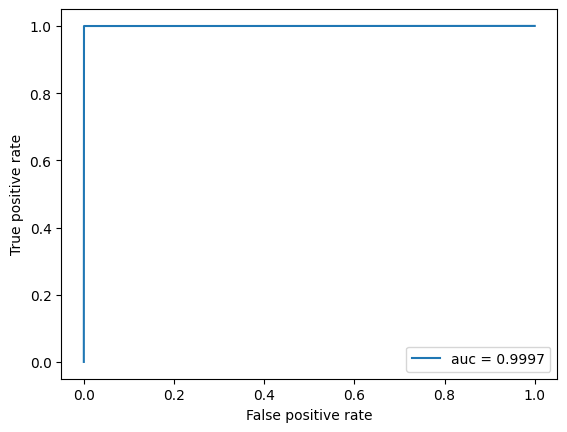

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test,
                                 y_test_pred, 
                                 pos_label=1)

roc_auc = auc(fpr, tpr)
plt.plot(fpr, 
         tpr,
         label=f'auc = {roc_auc:.4f}')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()


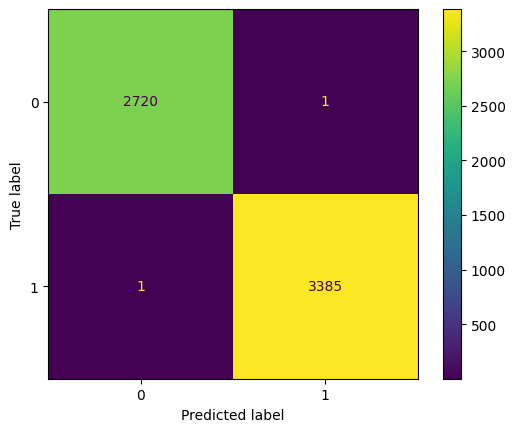

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
cm_display = ConfusionMatrixDisplay(confmat).plot()

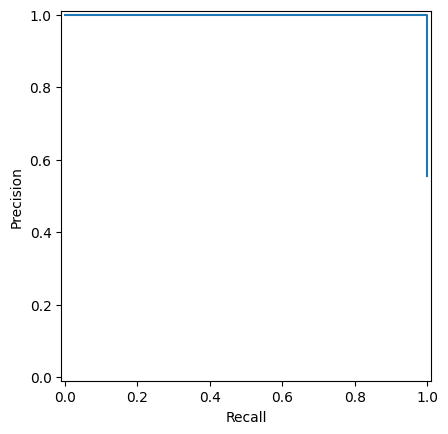

In [61]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test, y_test_pred, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()